# Social Choice

In [2]:
import csv
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_utils import *

sns.set(rc={'figure.figsize':(10,5)})

In [4]:
# Load profiles:
profiles = load_profiles('votes.csv')

# Get ground truth:
cand_with_gt, cand_gt_rank = np.loadtxt('truth.csv', delimiter=',', dtype=int)

# Create ground truth ranking
x_star = cand_with_gt[np.argsort(cand_gt_rank)]

# Map candidate names to dummy ones: (bypass partial profile):
x_dummy = np.arange(x_star.size)
cand_dummy_dict = {cand: dummy for cand, dummy in zip(x_star, x_dummy)}
dummy_cand_dict = {dummy: cand for cand, dummy in cand_dummy_dict.items()}

# Create partial profiles from votes based on ground truth values:
n, m = profiles.shape
filtered_profiles = profiles[np.in1d(profiles, cand_with_gt).reshape(n, m)].reshape(n, -1)
dummy_filtered_profiles = np.vectorize(cand_dummy_dict.__getitem__)(filtered_profiles)

## Methods ranking:

In [6]:
borda_ranking = borda(profiles)
copeland_ranking = copeland(profiles)
print(f"Borda (UW) rankings:    {list(borda_ranking)}")
print(f"Copeland (UW) rankings: {list(copeland_ranking)}")

Borda (UW) rankings:    [4, 12, 22, 19, 23, 13, 1, 7, 2, 0, 9, 18, 11, 17, 3, 24, 15, 16, 5, 6, 20, 21, 14, 10, 8]
Copeland (UW) rankings: [4, 12, 22, 19, 23, 13, 2, 1, 0, 9, 7, 18, 11, 17, 3, 24, 15, 6, 5, 20, 16, 21, 14, 10, 8]


In [8]:
borda_ranking = distance_truth_discovery(profiles, borda)
copeland_ranking = distance_truth_discovery(profiles, copeland)
print(f"D-TD (Borda) rankings:    {list(borda_ranking)}")
print(f"D-TD (Copeland) rankings: {list(copeland_ranking)}")

D-TD (Borda) rankings:    [4, 12, 19, 22, 23, 13, 1, 2, 7, 0, 9, 18, 17, 11, 3, 15, 24, 6, 5, 16, 20, 21, 14, 10, 8]
D-TD (Copeland) rankings: [4, 12, 22, 19, 23, 13, 2, 1, 9, 0, 7, 18, 11, 17, 3, 24, 15, 6, 5, 20, 16, 21, 14, 10, 8]


In [10]:
borda_ranking = proxy_truth_discovery(profiles, borda)
copeland_ranking = proxy_truth_discovery(profiles, copeland)
print(f"P-TD (Borda) rankings:    {list(borda_ranking)}")
print(f"P-TD (Copeland) rankings: {list(copeland_ranking)}")

P-TD (Borda) rankings:    [4, 12, 19, 22, 23, 13, 1, 2, 7, 0, 9, 18, 17, 11, 3, 15, 24, 6, 5, 16, 20, 21, 14, 10, 8]
P-TD (Copeland) rankings: [4, 12, 19, 22, 23, 13, 1, 2, 9, 0, 7, 18, 11, 17, 3, 24, 15, 6, 5, 20, 16, 21, 14, 10, 8]


In [12]:
borda_ranking = pca_truth_discovery(profiles, borda, k= 5)
copeland_ranking = pca_truth_discovery(profiles, copeland, k= 5)
print(f"PCA-TD (Borda) rankings:    {list(borda_ranking)}")
print(f"PCA-TD (Copeland) rankings: {list(copeland_ranking)}")

PCA-TD (Borda) rankings:    [4, 12, 22, 19, 23, 13, 1, 2, 7, 0, 9, 18, 11, 17, 3, 24, 15, 6, 16, 5, 20, 21, 14, 10, 8]
PCA-TD (Copeland) rankings: [4, 12, 22, 19, 23, 13, 2, 1, 0, 9, 7, 18, 11, 17, 3, 24, 15, 6, 5, 20, 16, 21, 14, 10, 8]


## Proxy distance vs True distance:

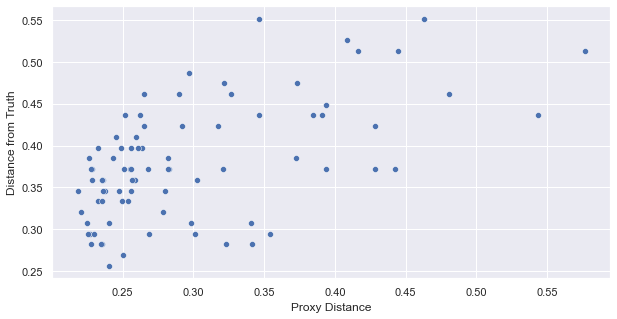

In [14]:
# Calculate distance from truth and proxy distance:
d_f_profiles_ind = np.argsort(dummy_filtered_profiles) # Sort once, x_dummy is 0...m anyway
dist_from_truth = np.apply_along_axis(lambda row: kt_distance(row, x_dummy), 1, d_f_profiles_ind)
proxy_dist = calculate_proxy_dist(dummy_filtered_profiles, kt_distance)

# Plot:
plot = sns.scatterplot(y=dist_from_truth, x=proxy_dist)
plot.set(ylabel = 'Distance from Truth', xlabel = 'Proxy Distance')
plt.show()

## Sampling:

Sampling with Borda:   0%|          | 0/17 [00:00<?, ?it/s]

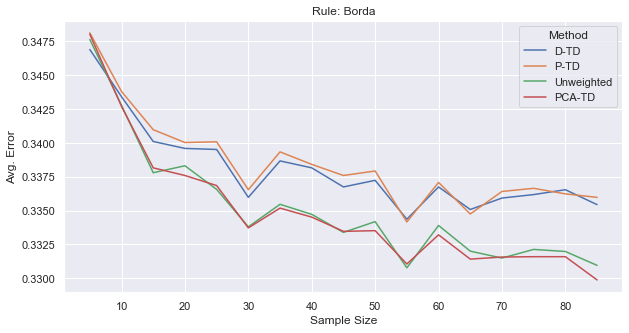

Sampling with Copeland:   0%|          | 0/17 [00:00<?, ?it/s]

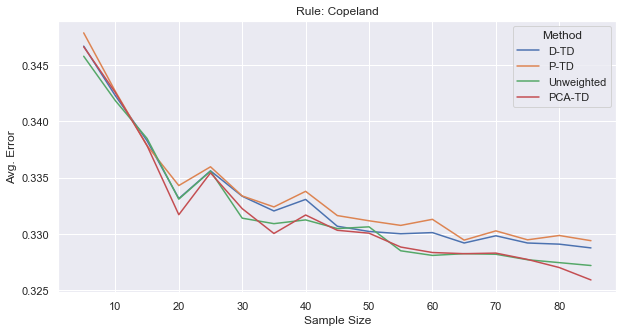

In [15]:

n, m = dummy_filtered_profiles.shape
rng = np.random.default_rng()  # Random numbers generator

rules = (borda, copeland)
sample_sizes = np.arange(5, n + 1, 5)
epochs = 500

for rule in rules:
    samples_dtd_errs = np.zeros(sample_sizes.size)
    samples_ptd_errs = np.zeros(sample_sizes.size)
    samples_uw_errs = np.zeros(sample_sizes.size)
    samples_pca_errs = np.zeros(sample_sizes.size)
    
    for i, sample_size in enumerate(tqdm(sample_sizes, desc=f'Sampling with {rule.__name__.title()}')):
        for _ in range(epochs):
            sample_ind = rng.choice(n, sample_size, replace=True)
            sample = dummy_filtered_profiles[sample_ind]
            dtd_rank = distance_truth_discovery(sample, rule)
            samples_dtd_errs[i] += kt_distance(x_dummy, dtd_rank.argsort())
            ptd_rank = proxy_truth_discovery(sample, rule)
            samples_ptd_errs[i] += kt_distance(x_dummy, ptd_rank.argsort())
            uw_rank = rule(sample)
            samples_uw_errs[i] += kt_distance(x_dummy, uw_rank.argsort())
            pca_rank = pca_truth_discovery(sample, rule)
            samples_pca_errs[i] += kt_distance(x_dummy, pca_rank.argsort())

        samples_dtd_errs[i] /= epochs
        samples_ptd_errs[i] /= epochs
        samples_uw_errs[i] /= epochs
        samples_pca_errs[i] /= epochs
    
    # Arrange results in DataFrame:
    df = pd.DataFrame({
        'Sample Size': sample_sizes,
        'D-TD': samples_dtd_errs,
        'P-TD': samples_ptd_errs,
        'Unweighted': samples_uw_errs,
        'PCA-TD': samples_pca_errs
    })

    df = pd.melt(df, ['Sample Size'], var_name='Method', value_name='Avg. Error')
    # Plot:
    plt.clf()
    plot = sns.lineplot(x='Sample Size', y='Avg. Error', hue='Method', data=df)
    plot.set_title(f'Rule: {rule.__name__.title()}')
    plot.get_figure().savefig(f"avg_error_{rule.__name__}.png")
    plt.show()


